# Los Angeles weather analysis

In [9]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

In [3]:
# read processed before dataset
df = pd.read_csv("Los_Angeles.csv", index_col=0)
df.set_index([pd.to_datetime(df.index)], inplace=True)

In [4]:
df

,TEMP,DEWP,SLP,STP,VISIB,WDSP,PRCP
2000-01-01,53.542857,35.100000,1022.214286,999.900000,9.014286,1.571429,14.284286
2000-01-08,55.942857,45.571429,1020.728571,999.900000,6.400000,1.142857,0.000000
2000-01-15,62.985714,51.714286,1018.885714,999.900000,9.128571,1.300000,0.071429
2000-01-22,57.885714,48.485714,1018.742857,999.900000,6.971429,1.500000,2.360752
2000-02-01,60.600000,43.785714,1021.357143,999.900000,8.714286,1.714286,0.000000
...,...,...,...,...,...,...,...
2019-10-22,74.728571,42.342857,1012.214286,5.900000,9.928571,0.957143,0.000000
2019-11-01,65.785714,39.814286,1015.514286,9.100000,8.357143,0.942857,0.000000
2019-11-08,66.600000,52.642857,1016.142857,9.771429,6.200000,0.900000,0.000000
2019-11-15,68.075000,45.550000,1014.925000,8.375000,8.675000,0.775000,0.000000


Our weather data contains measures of temperature, dew point, sea level pressure, station pressure, visibility, wind speed and precipitation amount. Here I will analyse each of this measurment.

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose time series data to trend, season and residuals
def decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    residual.dropna(inplace=True);
    
    # Original
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    
    # Trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    # Seasonality
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    # Resudials
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    return (residual, trend, seasonal)

## Temperature

In [6]:
temp = df.TEMP
temp

2000-01-01    53.542857
2000-01-08    55.942857
2000-01-15    62.985714
2000-01-22    57.885714
2000-02-01    60.600000
                ...    
2019-10-22    74.728571
2019-11-01    65.785714
2019-11-08    66.600000
2019-11-15    68.075000
2019-11-22    60.236090
Name: TEMP, Length: 956, dtype: float64


To predict weather data for 2019 year, we will use ARIMA model.To do that we need to decompose data to make our time series data stationary - extract trend and season from it.


__Decomposing__

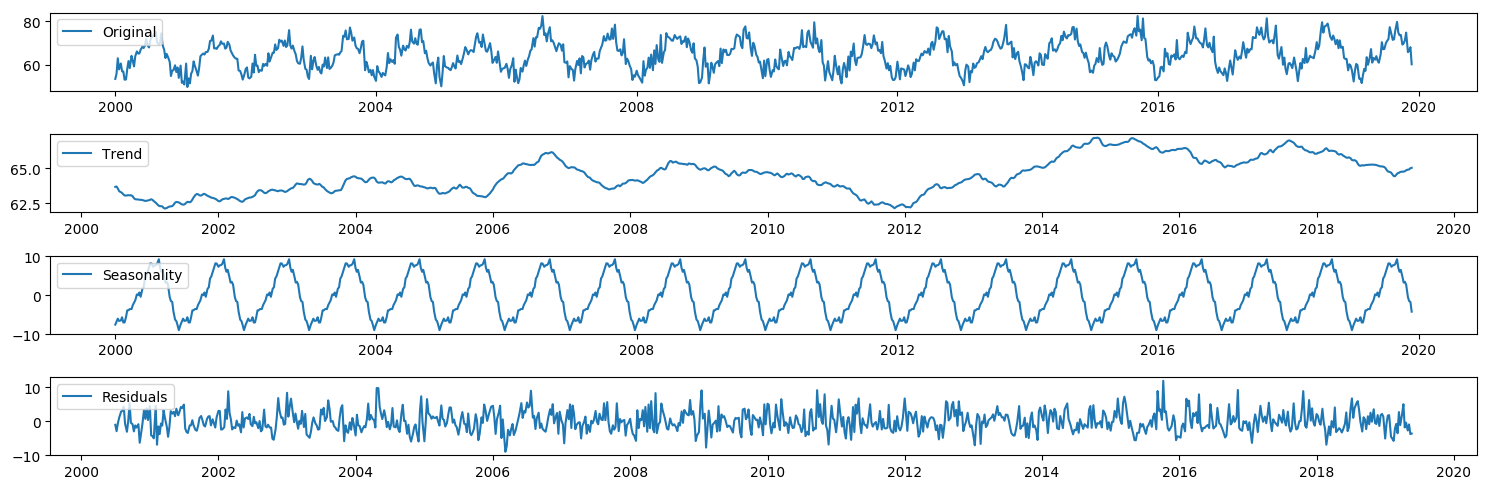

In [10]:
# 48, cause there are 4 weeks for each month, and there are 12 month, so period should be 4*12 = 48
temp_results = decompose(temp, 48)
temp_res = temp_results[0]

In [11]:
temp_res

2000-07-01   -1.090187
2000-07-08   -2.973034
2000-07-15   -0.564975
2000-07-22    1.057432
2000-08-01    2.786427
                ...   
2019-04-22   -0.446908
2019-05-01   -2.764812
2019-05-08   -0.976145
2019-05-15   -3.832532
2019-05-22   -3.674880
Name: TEMP, Length: 908, dtype: float64

Now, lets check stationarity of our residuals. To do that, I'll use ADF test. To be 99% confident, that ts is stationary, ADF statistic should be less than critical value of 1%. Also we can check stationarity be p-value - it should be less than 0.01.

In [12]:
from statsmodels.tsa.stattools import adfuller

def df_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
df_test(temp_res)

ADF Statistic: -10.508054
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


__Selecting parameters of the model__

As we can see, our residuals are stationary, do now we can use ARIMA. ARIMA has 3 parameters: __p, d and  q__. __d__ responds for differencing level(another way to make ts stationary), but, as we already did our data stationary, we can set d=0 to not difference our ts one more time. Now, lets find p and q.

To find p I'll use partial autocorrelation function (PACF), and to find q - autocorrelation function (ACF). We need to take first biggest lag, which is above significance line. 

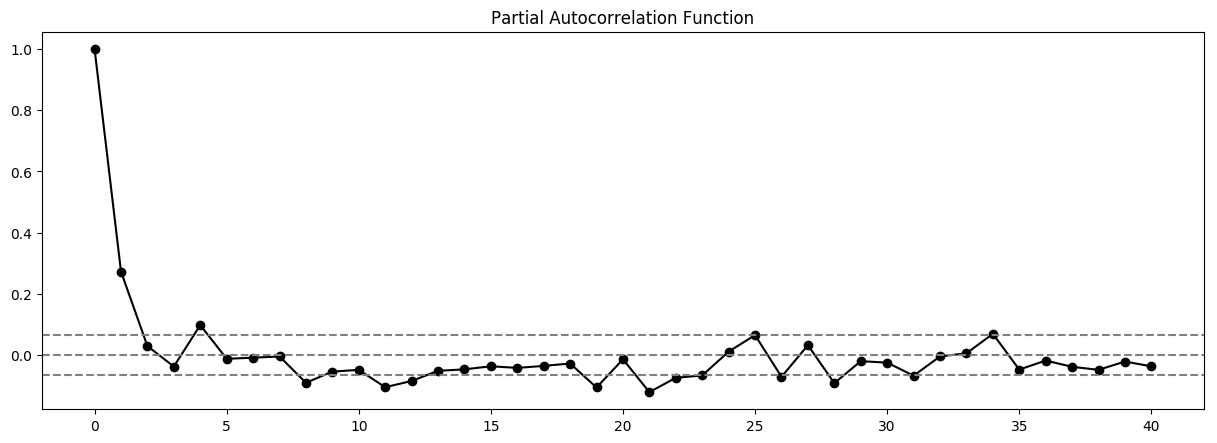

In [14]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

lag_pacf = pacf(temp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, here first biggest lag above signifacance line is 1, so __p=1__.

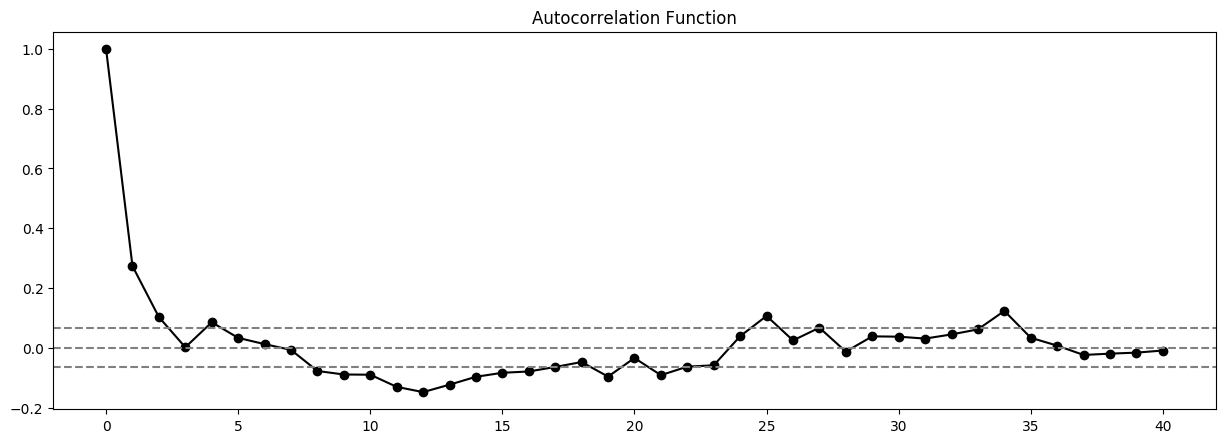

In [15]:
lag_acf = acf(temp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here, __q=2__

__Fitting model and predicting__

In [16]:
temp_model = ARIMA(temp_res, order=(1, 0, 2))
temp_model_fit = temp_model.fit(disp=-1)

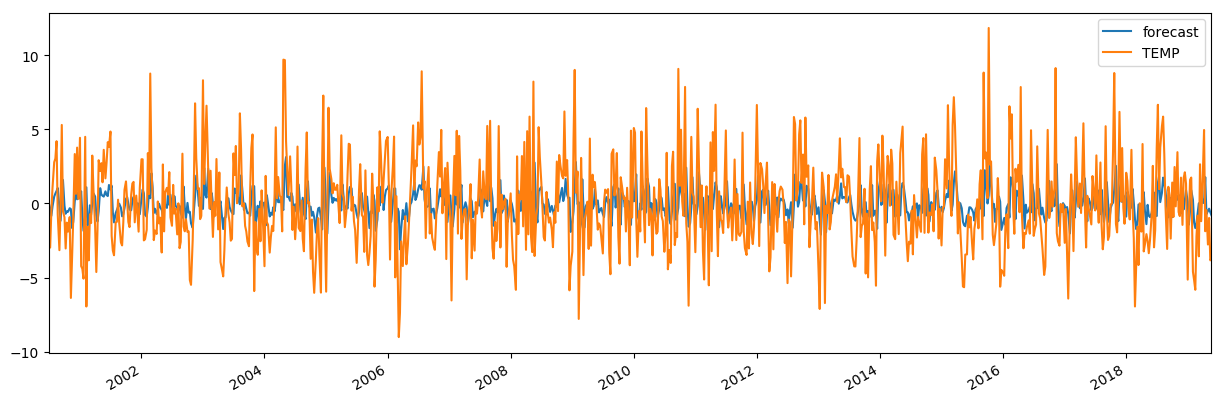

In [17]:
# Actual vs Fitted
temp_model_fit.plot_predict(dynamic=False)
plt.show()

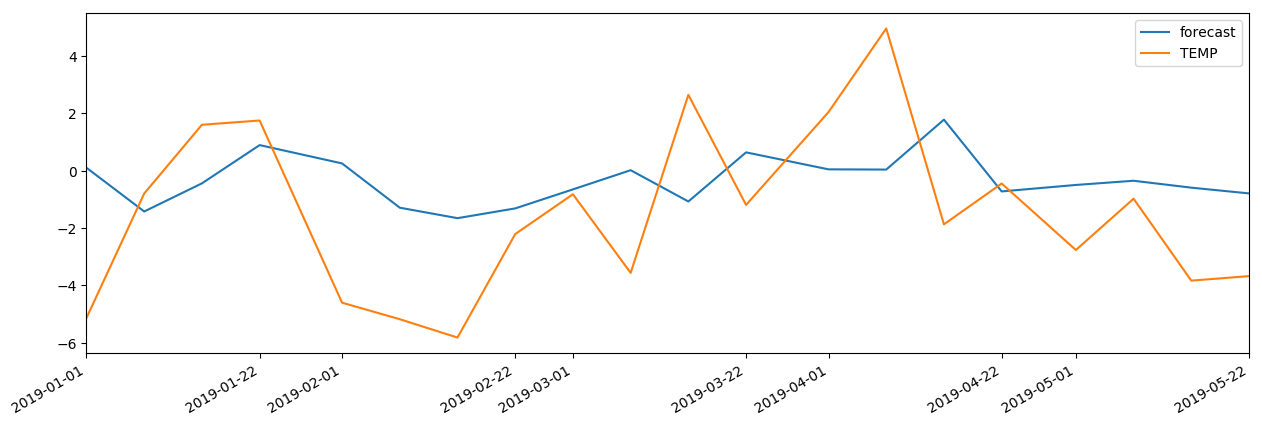

In [18]:
# only 2019 year
temp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Dew point

In [19]:
dewp = df.DEWP
dewp

2000-01-01    35.100000
2000-01-08    45.571429
2000-01-15    51.714286
2000-01-22    48.485714
2000-02-01    43.785714
                ...    
2019-10-22    42.342857
2019-11-01    39.814286
2019-11-08    52.642857
2019-11-15    45.550000
2019-11-22    40.881955
Name: DEWP, Length: 956, dtype: float64

__Decomposing__

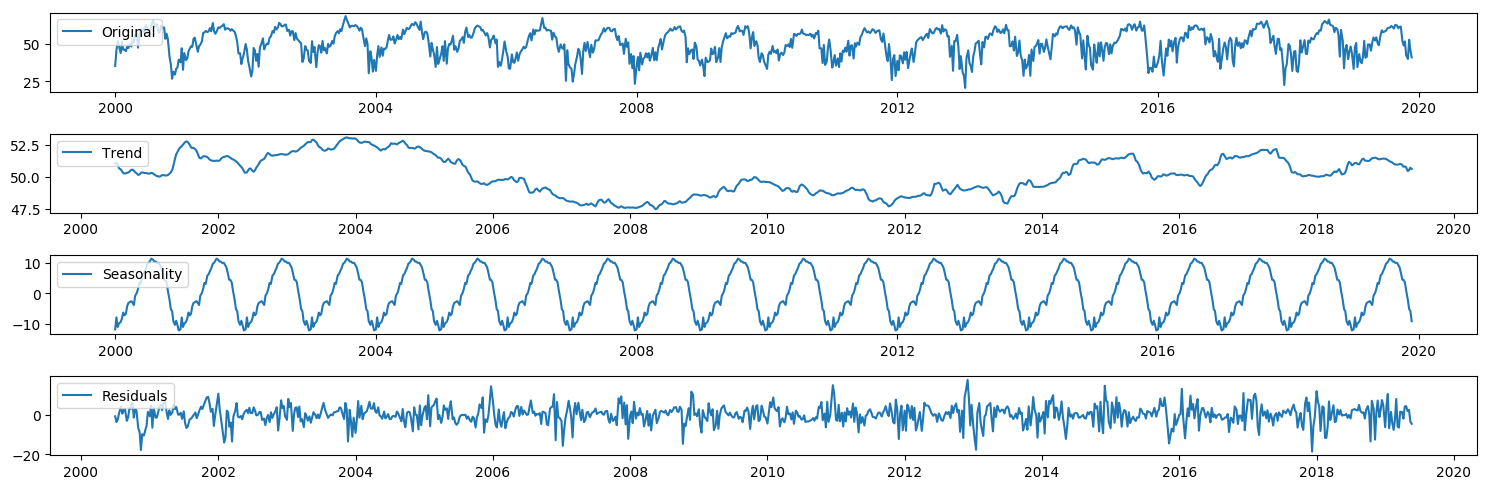

In [20]:
dewp_results = decompose(dewp, 48)
dewp_res = dewp_results[0]

In [21]:
dewp_res

2000-07-01   -0.917871
2000-07-08   -3.747433
2000-07-15   -2.446579
2000-07-22    0.790224
2000-08-01    4.022093
                ...   
2019-04-22    4.296286
2019-05-01    1.609248
2019-05-08    2.307799
2019-05-15   -3.589953
2019-05-22   -4.650505
Name: DEWP, Length: 908, dtype: float64

In [22]:
df_test(dewp_res)

ADF Statistic: -10.931813
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Residuals for dew point is stationary now, so we can select parameters for model.

__Selecting parameters of the model__

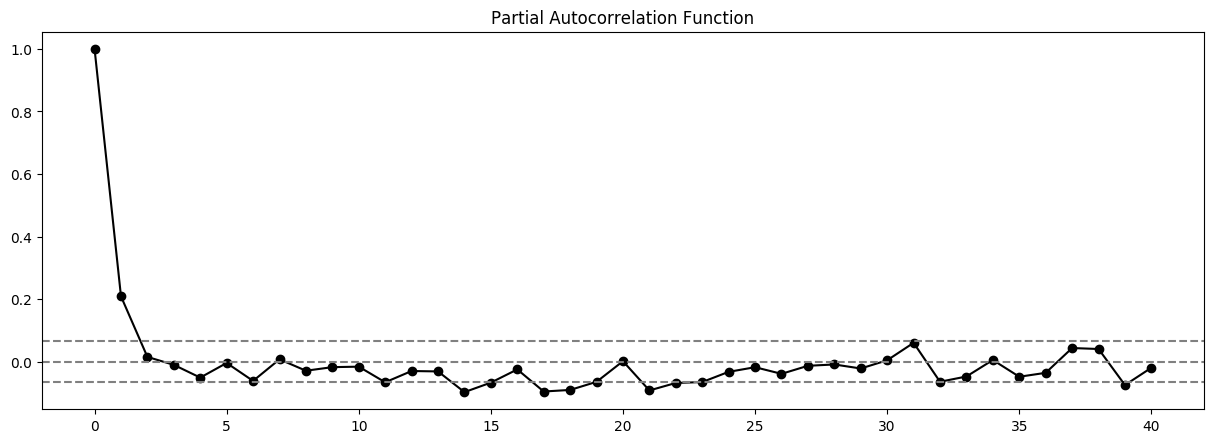

In [23]:
lag_pacf = pacf(dewp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

So, __p=1__.

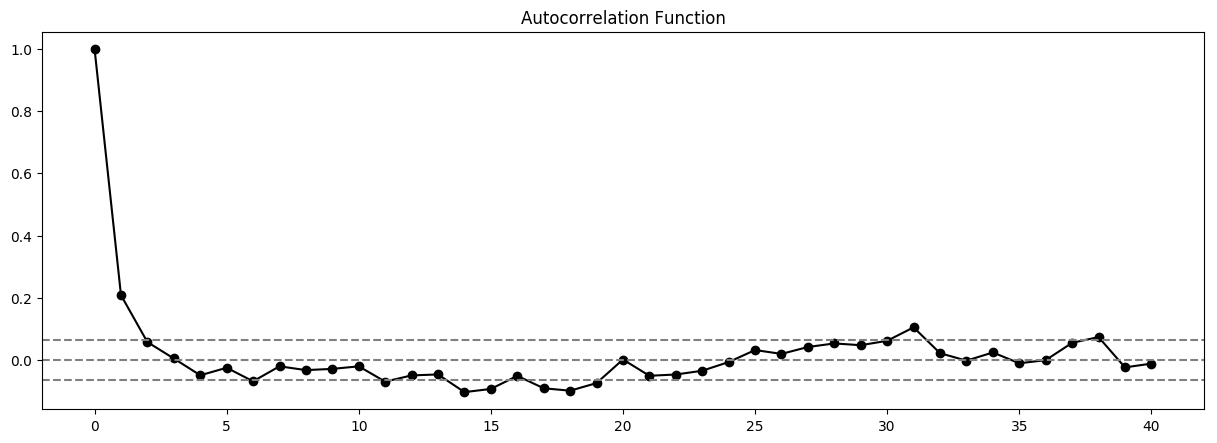

In [24]:
lag_acf = acf(dewp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dewp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=1__

__Fitting model and predicting__

In [25]:
dewp_model = ARIMA(dewp_res, order=(1, 0, 1))
dewp_model_fit = dewp_model.fit(disp=-1)

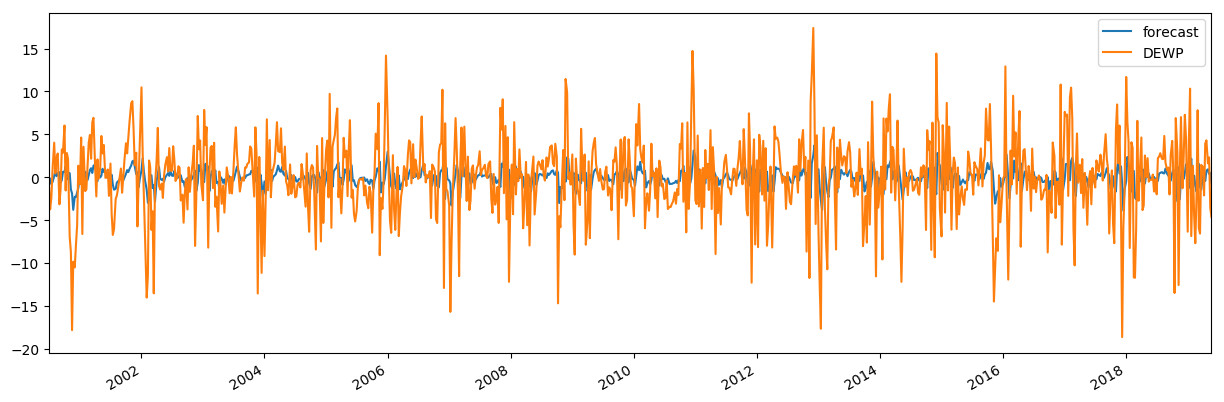

In [26]:
# Actual vs Fitted
dewp_model_fit.plot_predict(dynamic=False)
plt.show()

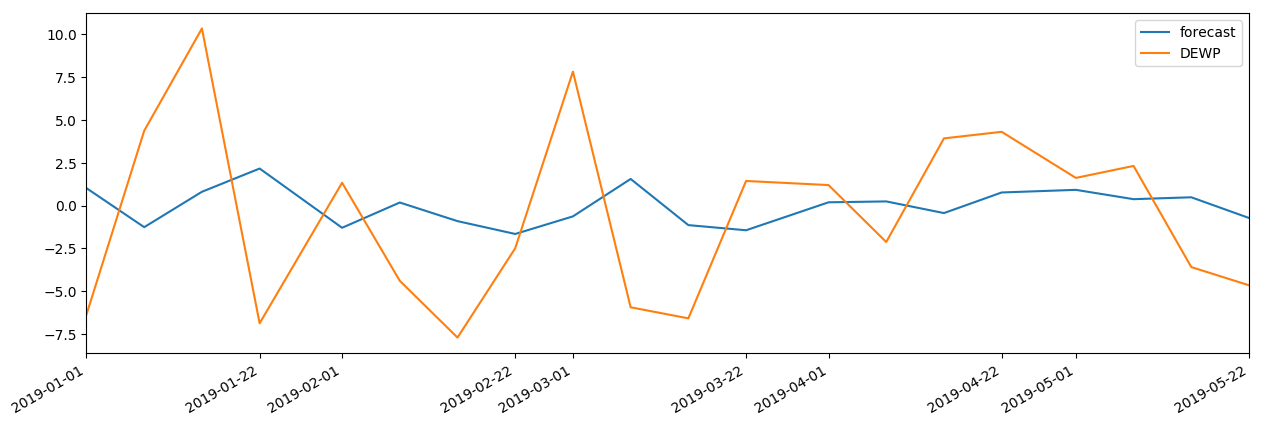

In [27]:
# only 2019 year
dewp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Sea level pressure

In [28]:
slp = df.SLP
slp

2000-01-01    1022.214286
2000-01-08    1020.728571
2000-01-15    1018.885714
2000-01-22    1018.742857
2000-02-01    1021.357143
                 ...     
2019-10-22    1012.214286
2019-11-01    1015.514286
2019-11-08    1016.142857
2019-11-15    1014.925000
2019-11-22    1016.990226
Name: SLP, Length: 956, dtype: float64

__Decomposing__

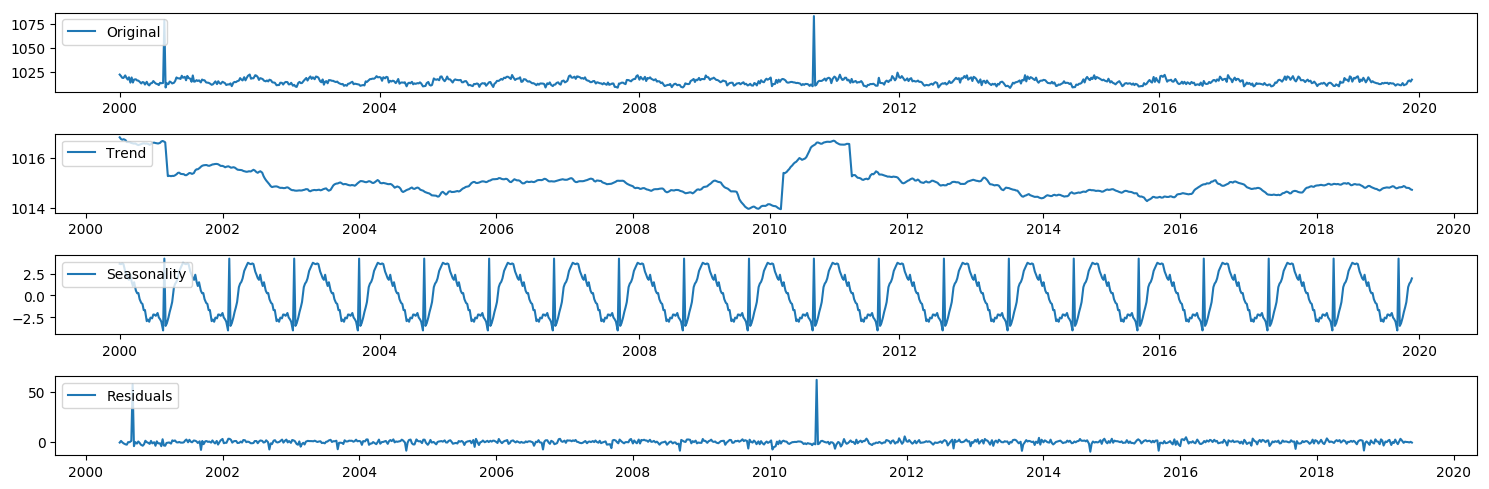

In [29]:
slp_results = decompose(slp, 48)
slp_res = slp_results[0]

In [30]:
slp_res

2000-07-01   -0.628163
2000-07-08    0.994834
2000-07-15   -0.401730
2000-07-22   -1.460549
2000-08-01   -2.420879
                ...   
2019-04-22   -0.043884
2019-05-01   -0.155852
2019-05-08   -0.535878
2019-05-15    0.095045
2019-05-22   -0.643663
Name: SLP, Length: 908, dtype: float64

In [31]:
df_test(slp_res)

ADF Statistic: -30.559400
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


Data for sea level pressure is stationaty, we can do further calculation

__Selecting parameters of the model__

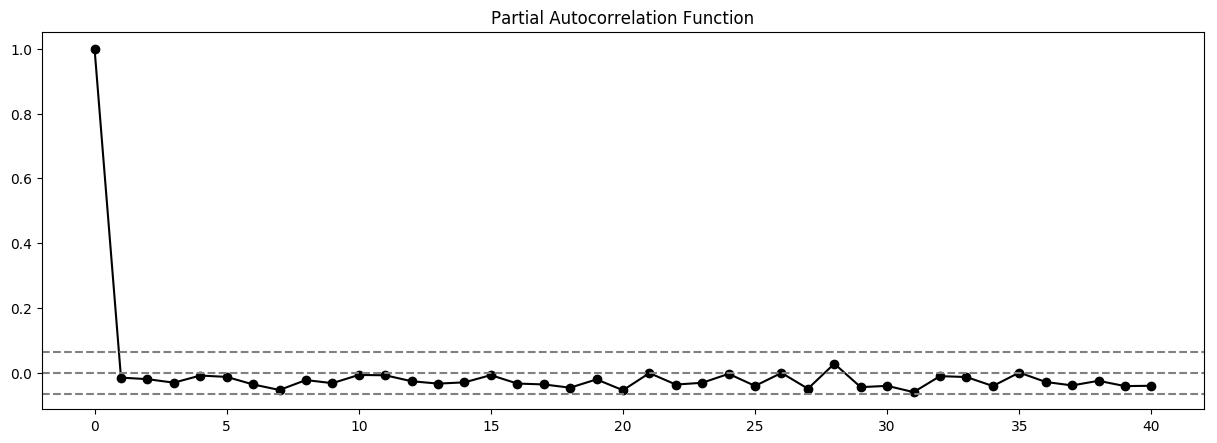

In [32]:
lag_pacf = pacf(slp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=4__

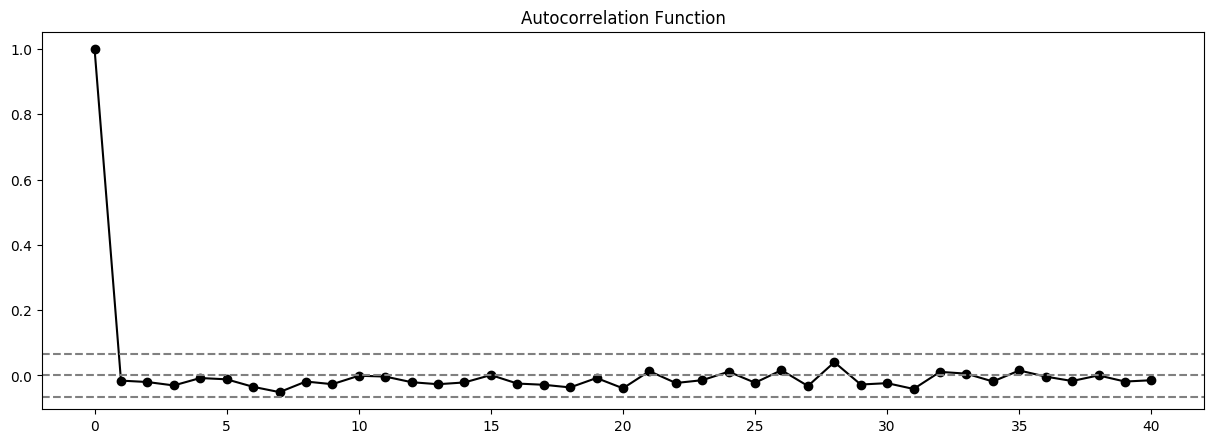

In [33]:
lag_acf = acf(slp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(slp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=4__

Here, we should take p and q as 0, but then prediction will be just straight line, which will not tell as a lot about weather changes. Smallest parameter we can take is 4, so we take p=q=4.

__Fitting model and predicting__

In [34]:
slp_model = ARIMA(slp_res, order=(4, 0, 4))
slp_model_fit = slp_model.fit(disp=-1)

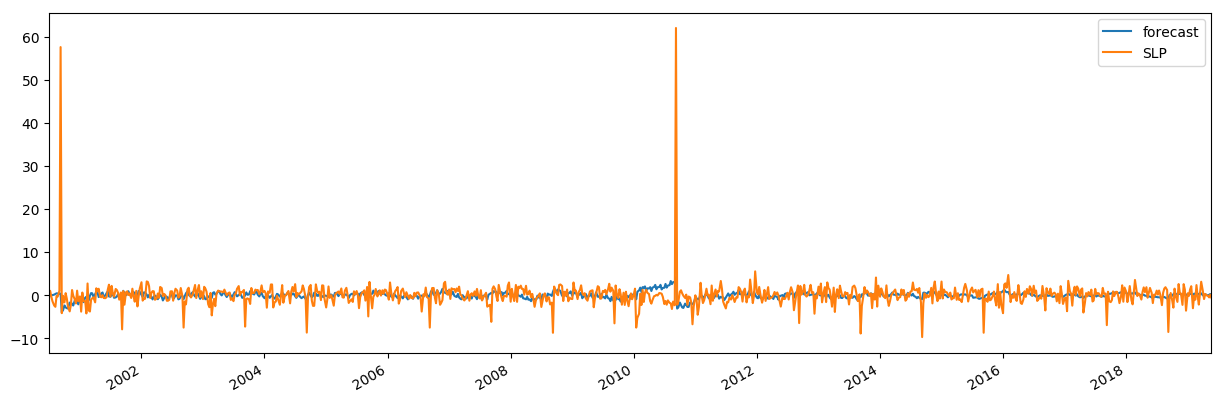

In [35]:
# Actual vs Fitted
slp_model_fit.plot_predict(dynamic=False)
plt.show()

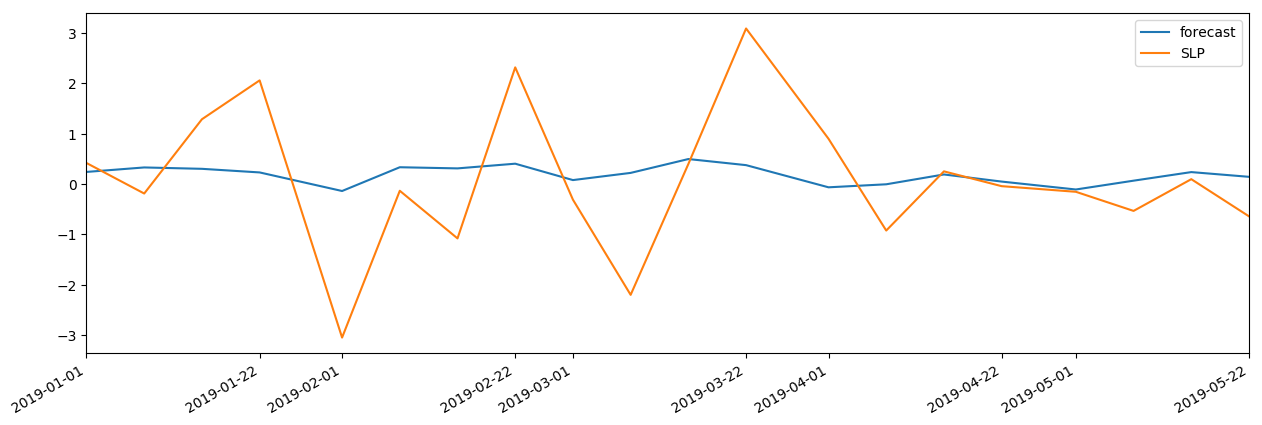

In [55]:
# only 2019 year
slp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Station pressure

In [36]:
stp = df.STP
stp

2000-01-01    999.900000
2000-01-08    999.900000
2000-01-15    999.900000
2000-01-22    999.900000
2000-02-01    999.900000
                 ...    
2019-10-22      5.900000
2019-11-01      9.100000
2019-11-08      9.771429
2019-11-15      8.375000
2019-11-22    270.748120
Name: STP, Length: 956, dtype: float64

__Decomposing__

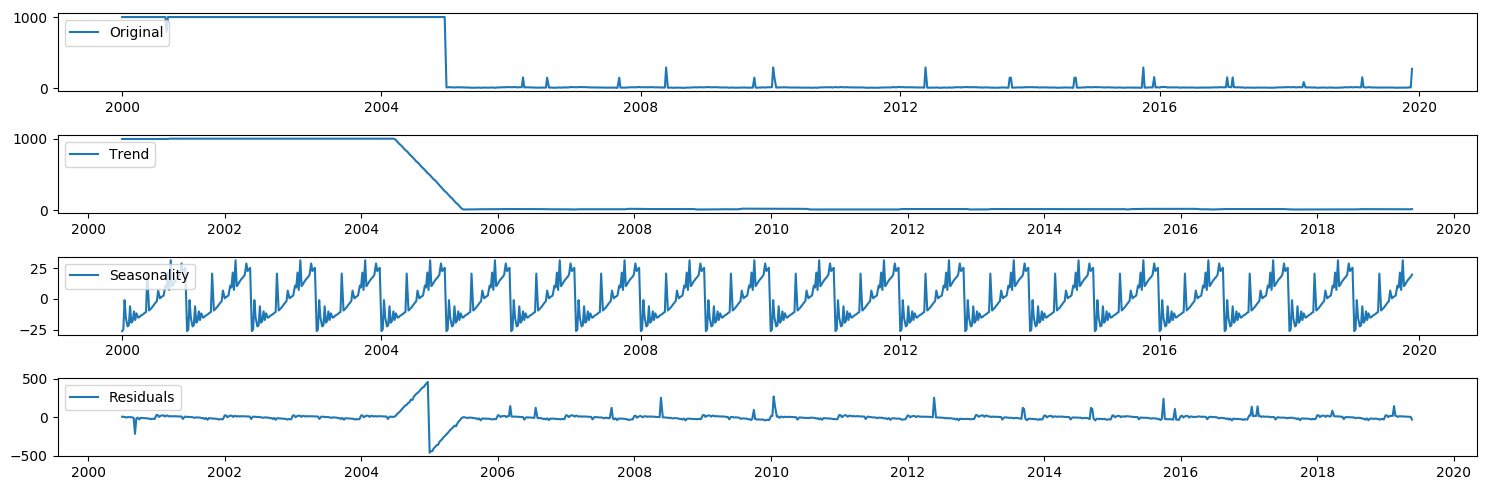

In [37]:
stp_results = decompose(stp, 48)
stp_res = stp_results[0]

In [38]:
stp_res

2000-07-01     8.557801
2000-07-08     7.201504
2000-07-15     6.073543
2000-07-22    -2.433631
2000-08-01     3.833678
                ...    
2019-04-22     9.451955
2019-05-01     8.123798
2019-05-08     6.469240
2019-05-15     5.920051
2019-05-22   -28.560926
Name: STP, Length: 908, dtype: float64

In [39]:
df_test(stp_res)

ADF Statistic: -8.775727
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


Data is stationary

__Selecting parameters of the model__

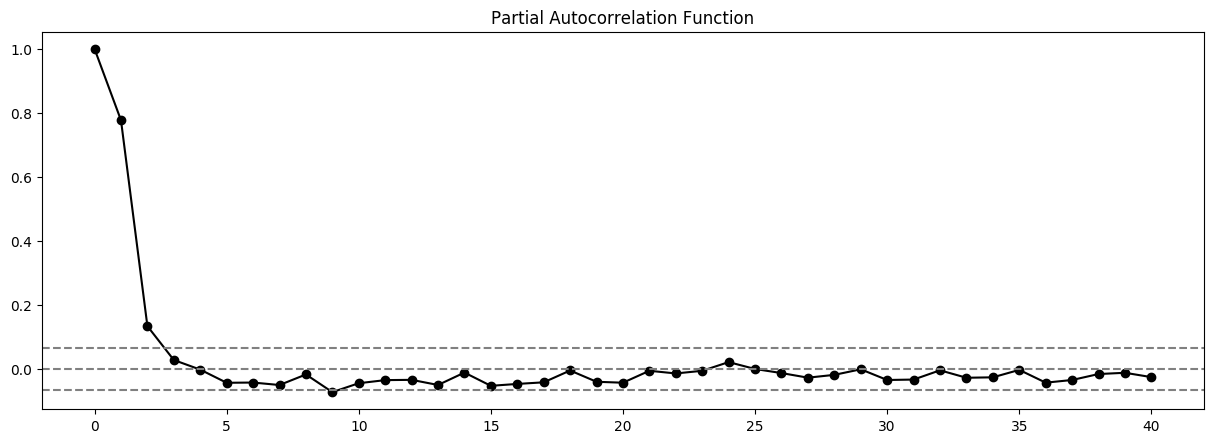

In [40]:
lag_pacf = pacf(stp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=2__

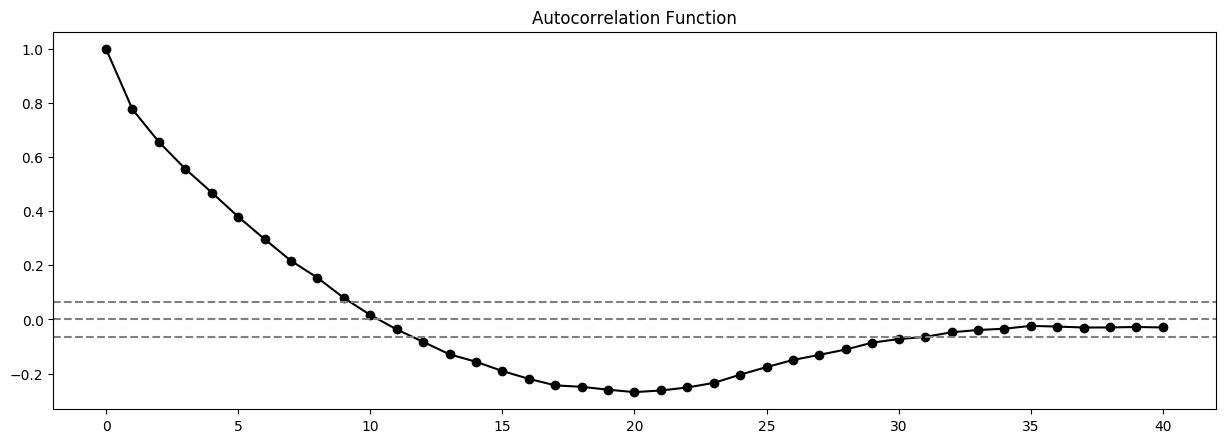

In [41]:
lag_acf = acf(stp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here looks like q can be 8 or even 9, but biggest allowed value for this model is 2, and as we can see, it produces quite well forecast. So, __q=2__

__Fitting model and predicting__

In [42]:
stp_model = ARIMA(stp_res, order=(2, 0, 2))
stp_model_fit = stp_model.fit(disp=-1)

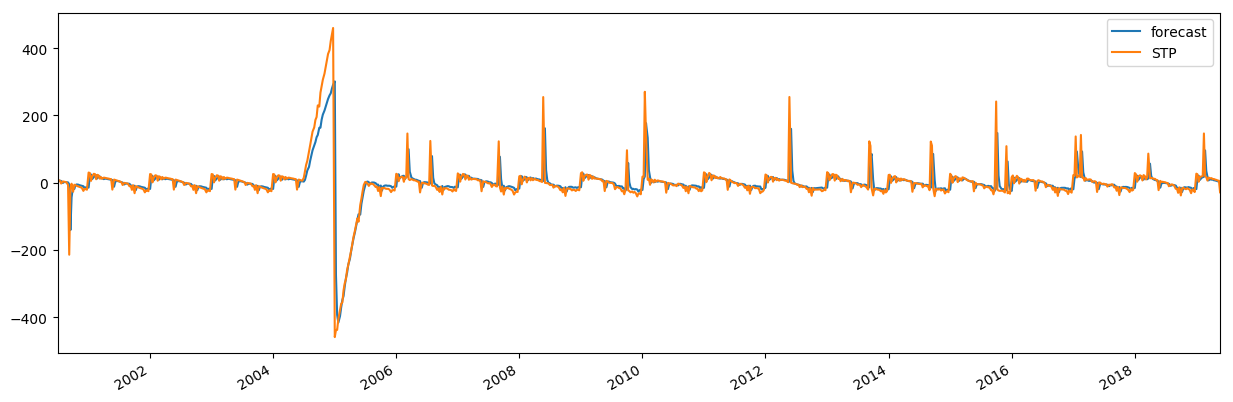

In [43]:
## Actual vs Fitted
stp_model_fit.plot_predict(dynamic=False)
plt.show()

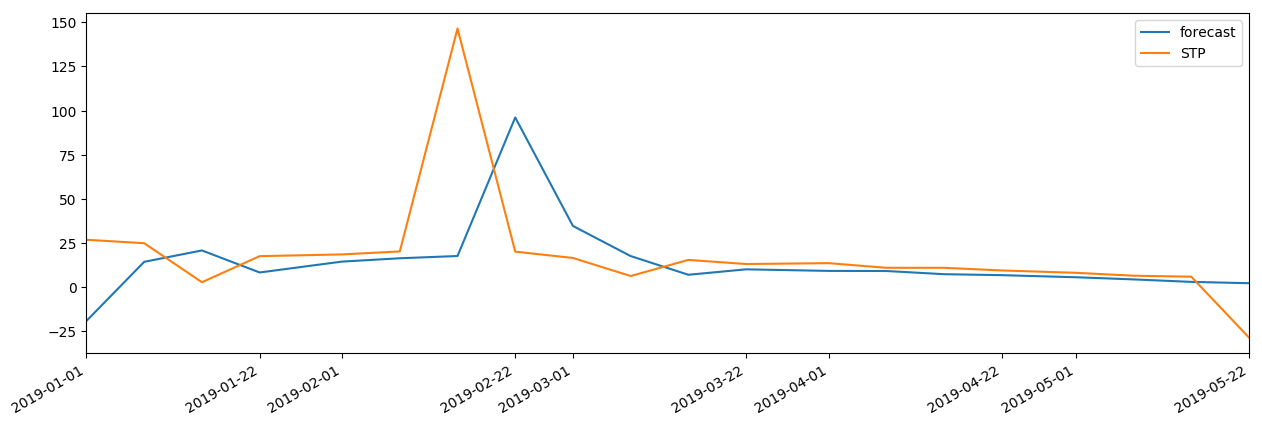

In [44]:
# only 2019 year
stp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Visibility

In [45]:
visib = df.VISIB
visib

2000-01-01    9.014286
2000-01-08    6.400000
2000-01-15    9.128571
2000-01-22    6.971429
2000-02-01    8.714286
                ...   
2019-10-22    9.928571
2019-11-01    8.357143
2019-11-08    6.200000
2019-11-15    8.675000
2019-11-22    8.478947
Name: VISIB, Length: 956, dtype: float64

__Decomposing__

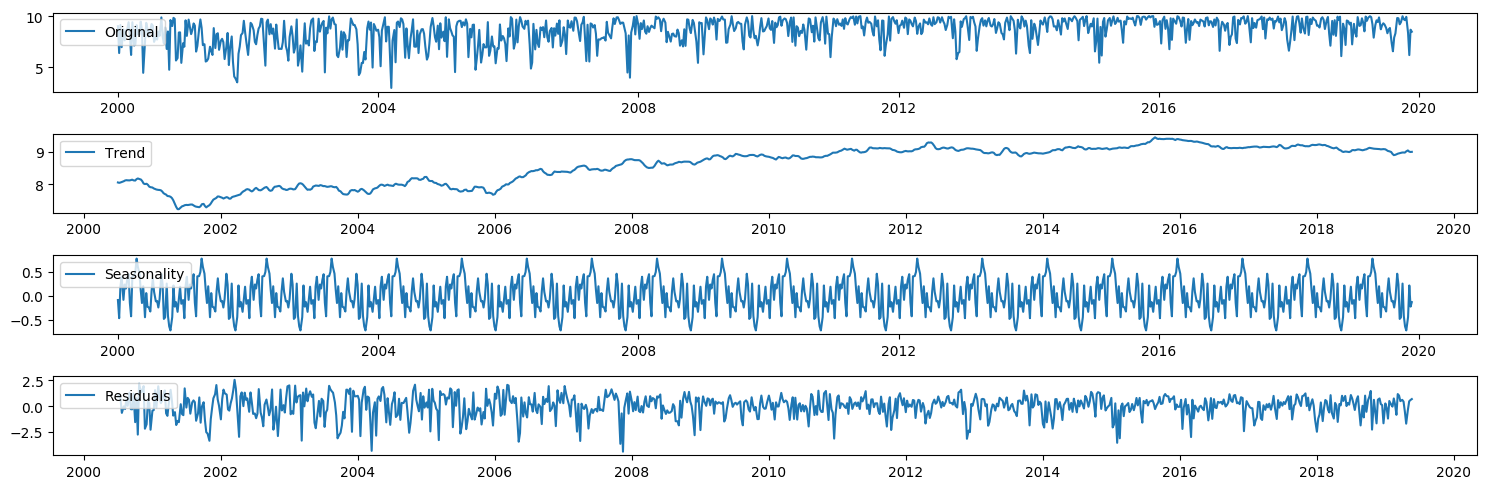

In [46]:
visib_results = decompose(visib, 48)
visib_res = visib_results[0]

In [47]:
visib_res

2000-07-01    0.917506
2000-07-08    1.094245
2000-07-15    0.645208
2000-07-22   -0.664010
2000-08-01   -0.030121
                ...   
2019-04-22   -1.707740
2019-05-01   -0.384307
2019-05-08    0.462576
2019-05-15    0.586617
2019-05-22    0.678934
Name: VISIB, Length: 908, dtype: float64

In [48]:
df_test(visib_res)

ADF Statistic: -24.503115
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


Visibility data is stationary

__Selecting parameters of the model__

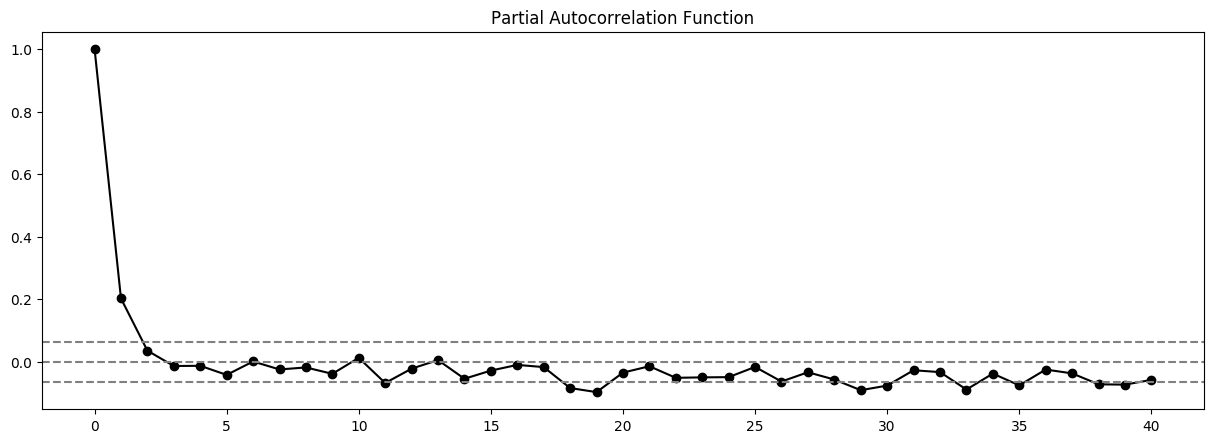

In [49]:
lag_pacf = pacf(visib_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=1__

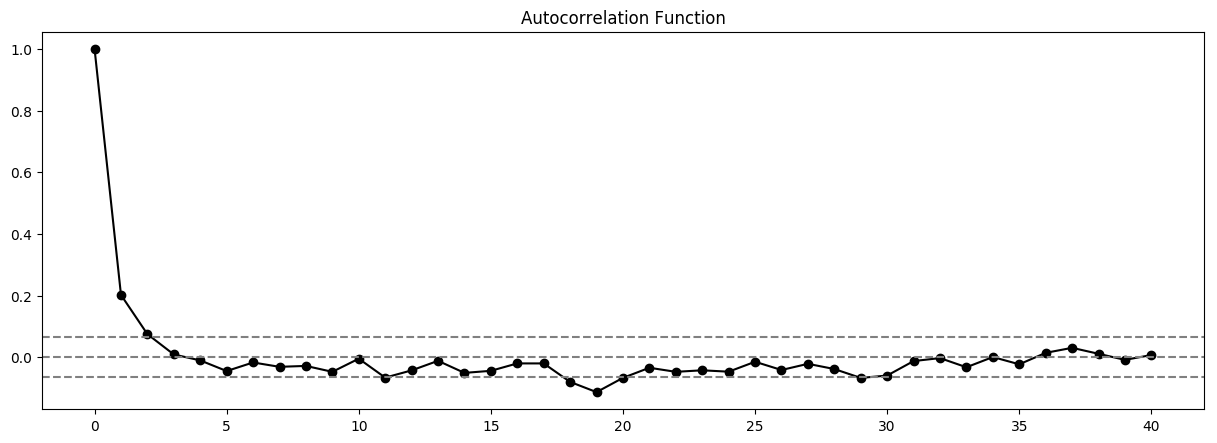

In [50]:
lag_acf = acf(visib_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(visib_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=2__

__Fitting model and predicting__

In [51]:
visib_model = ARIMA(visib_res, order=(1, 0, 2))
visib_model_fit = visib_model.fit(disp=-1)

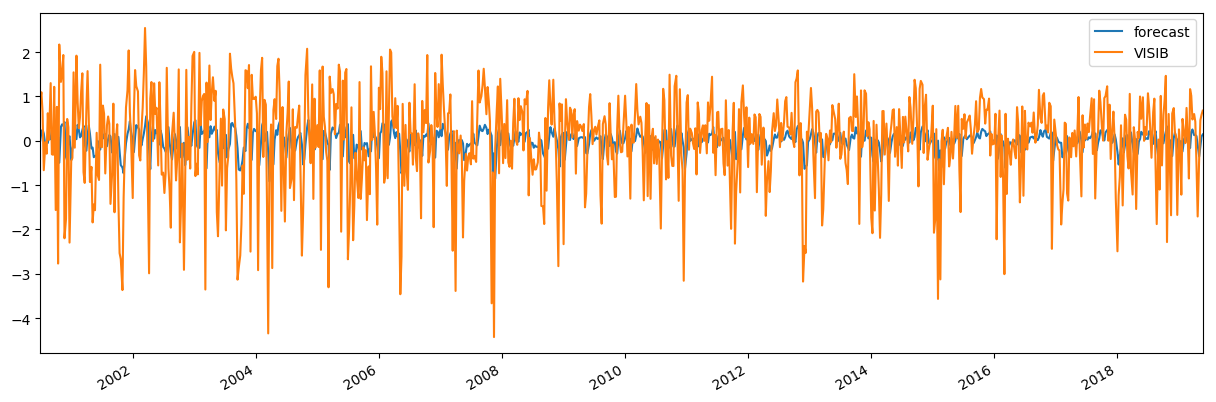

In [52]:
# Actual vs Fitted
visib_model_fit.plot_predict(dynamic=False)
plt.show()

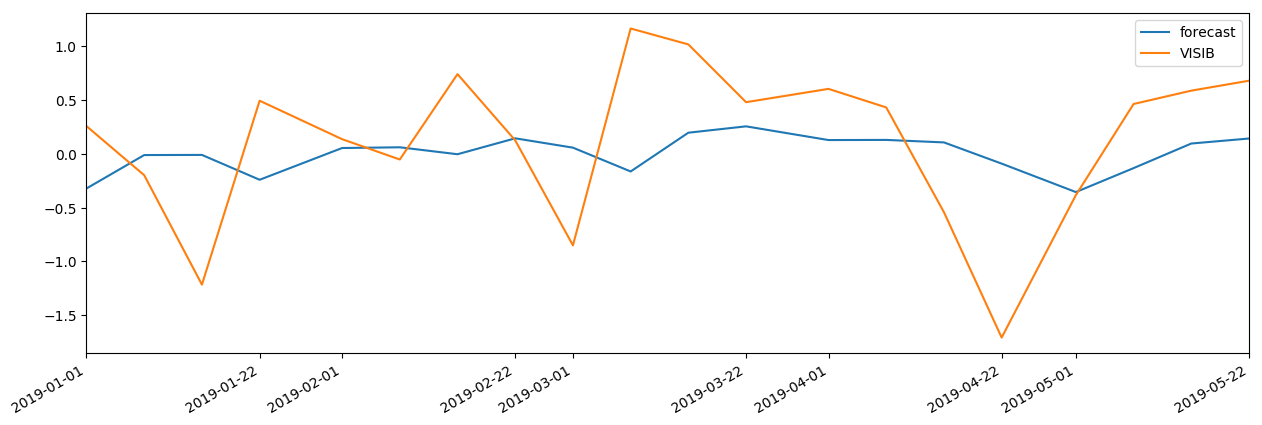

In [53]:
# only 2019 year
visib_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Wind speed

In [54]:
wdsp = df.WDSP
wdsp

2000-01-01    1.571429
2000-01-08    1.142857
2000-01-15    1.300000
2000-01-22    1.500000
2000-02-01    1.714286
                ...   
2019-10-22    0.957143
2019-11-01    0.942857
2019-11-08    0.900000
2019-11-15    0.775000
2019-11-22    1.240602
Name: WDSP, Length: 956, dtype: float64

__Decomposition__

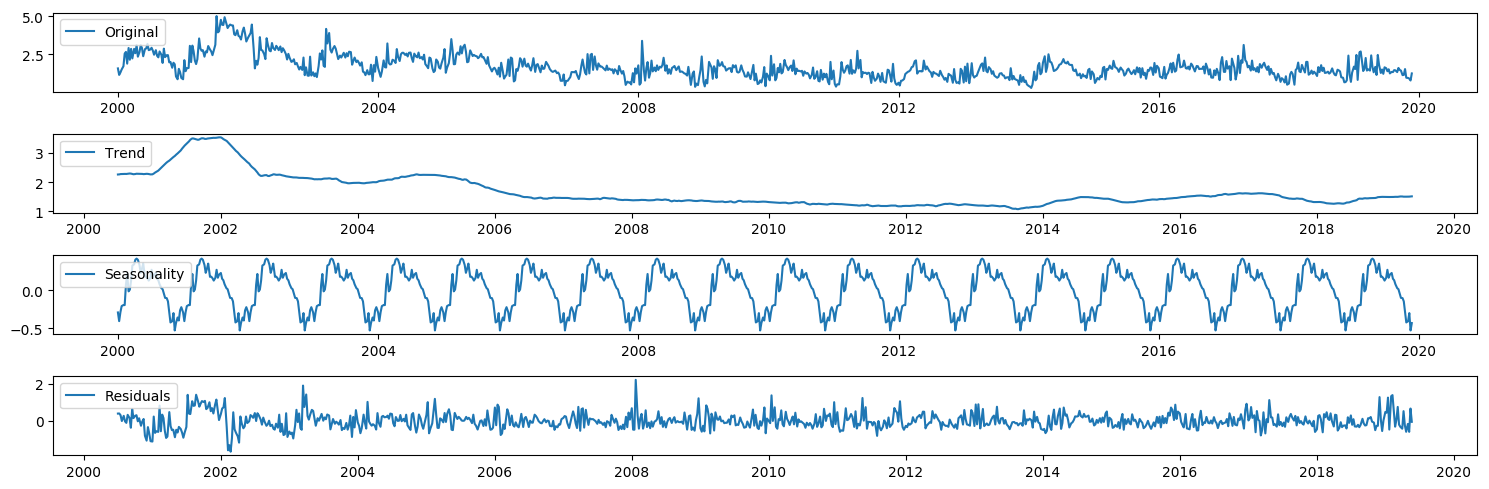

In [56]:
wdsp_results = decompose(wdsp, 48)
wdsp_res = wdsp_results[0]

In [57]:
wdsp_res

2000-07-01    0.393173
2000-07-08    0.398288
2000-07-15    0.306167
2000-07-22   -0.008143
2000-08-01    0.270476
                ...   
2019-04-22   -0.589827
2019-05-01   -0.164757
2019-05-08   -0.591386
2019-05-15    0.664434
2019-05-22   -0.051279
Name: WDSP, Length: 908, dtype: float64

In [58]:
df_test(wdsp_res)

ADF Statistic: -8.467266
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


Wind speed data is stationary now

__Selecting parameters of the model__

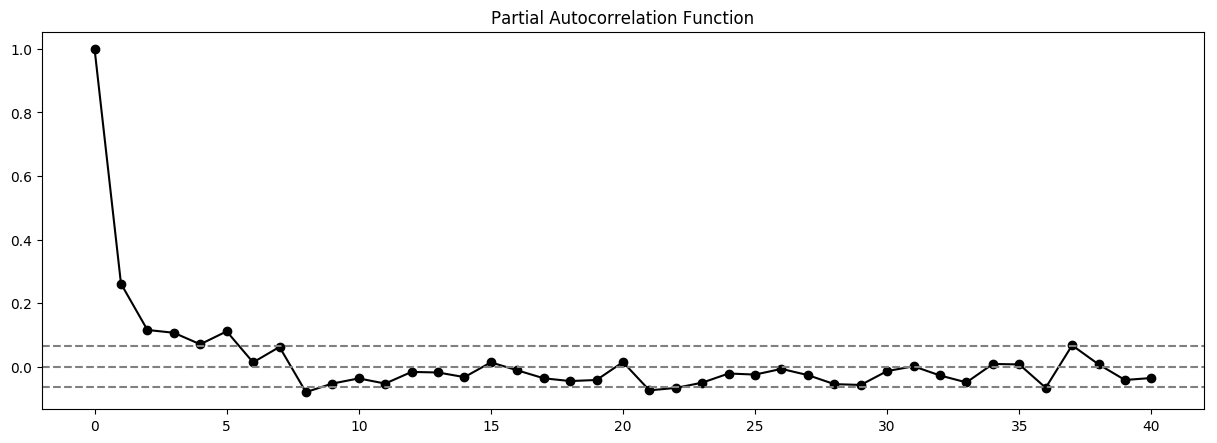

In [59]:
lag_pacf = pacf(wdsp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=5__

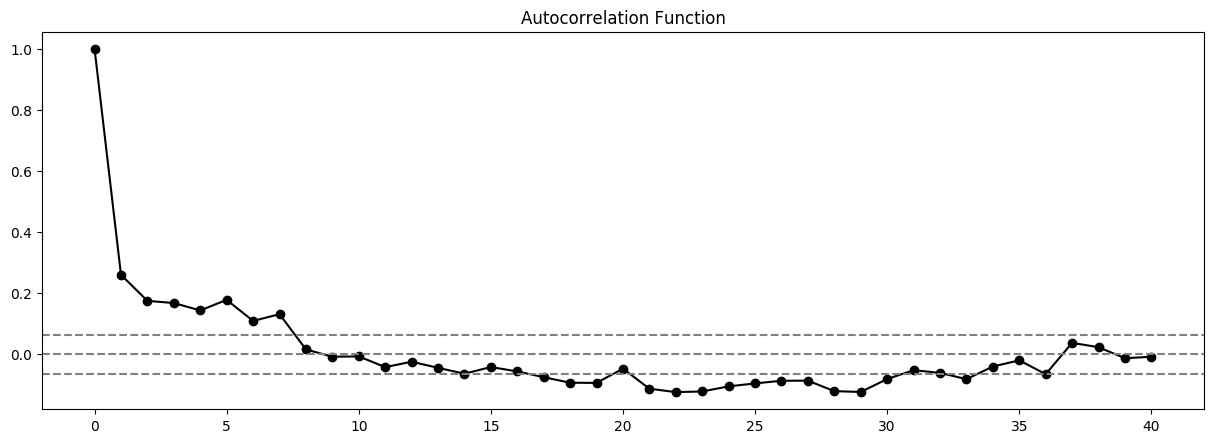

In [60]:
lag_acf = acf(wdsp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wdsp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

Here we can not take q=7, instead we take __q=2__

__Fitting model and predicting__

In [61]:
wdsp_model = ARIMA(wdsp_res, order=(5, 0, 2))
wdsp_model_fit = wdsp_model.fit(disp=-1)

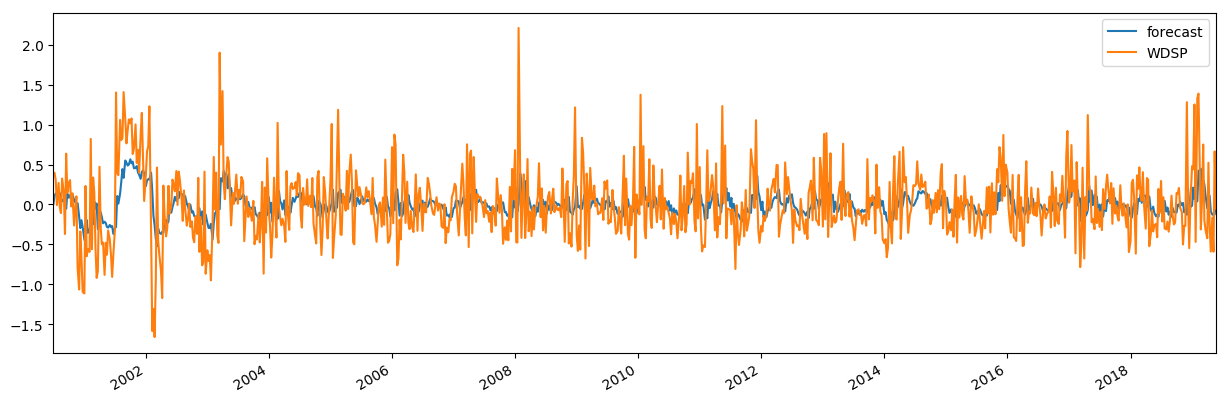

In [62]:
# Actual vs Fitted
wdsp_model_fit.plot_predict(dynamic=False)
plt.show()

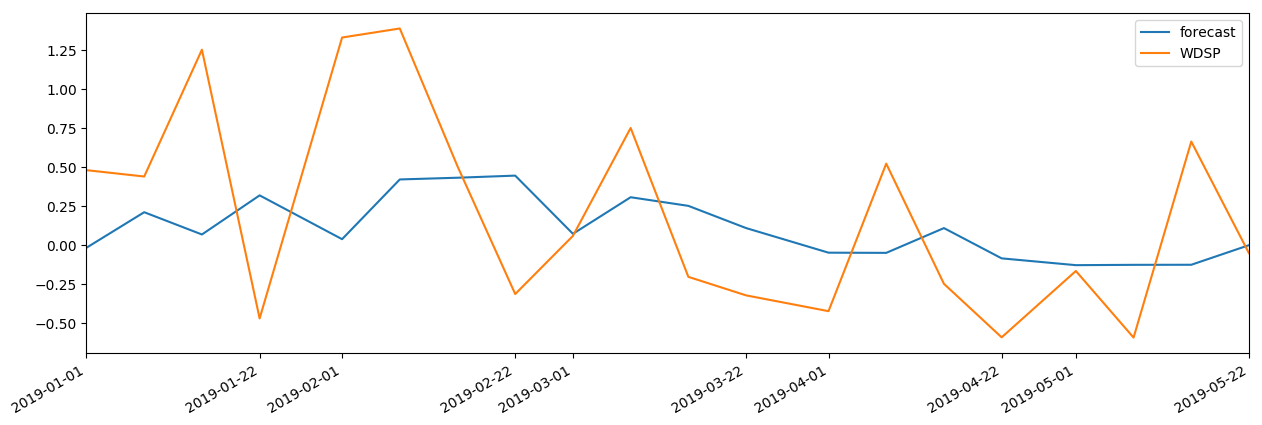

In [63]:
# only 2019 year
wdsp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

## Precipitation amount

In [64]:
prcp = df.PRCP
prcp

2000-01-01    14.284286
2000-01-08     0.000000
2000-01-15     0.071429
2000-01-22     2.360752
2000-02-01     0.000000
                ...    
2019-10-22     0.000000
2019-11-01     0.000000
2019-11-08     0.000000
2019-11-15     0.000000
2019-11-22     0.778045
Name: PRCP, Length: 956, dtype: float64

__Decomposition__

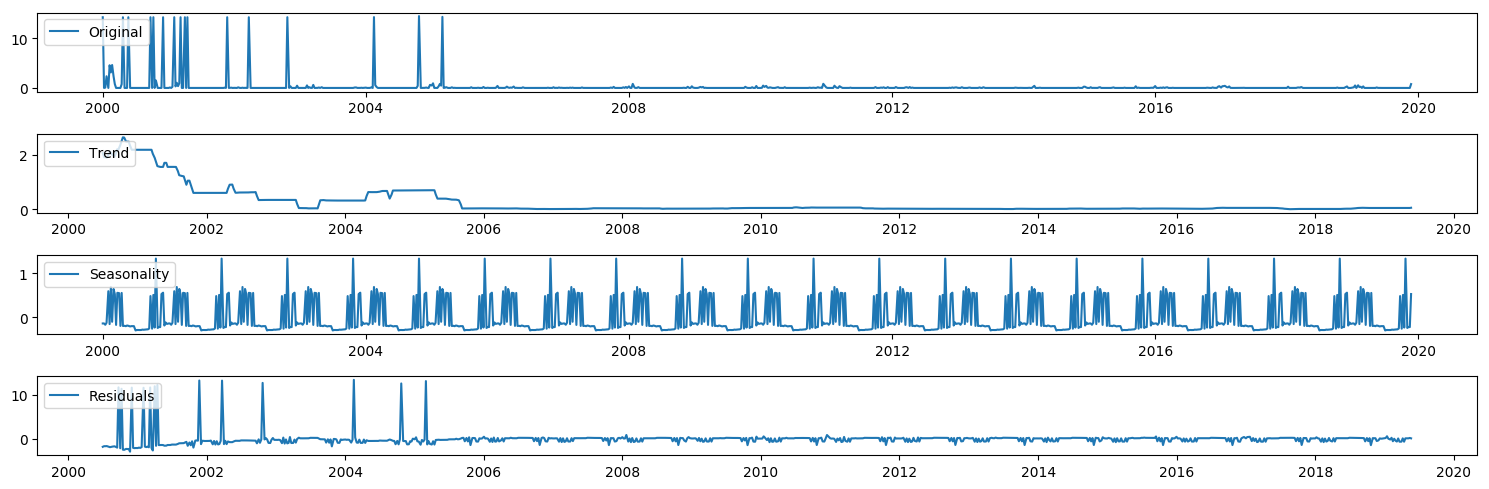

In [65]:
prcp_results = decompose(prcp, 48)
prcp_res = prcp_results[0]

In [66]:
prcp_res

2000-07-01   -1.762038
2000-07-08   -1.623019
2000-07-15   -1.624784
2000-07-22   -1.600421
2000-08-01   -1.728097
                ...   
2019-04-22    0.141104
2019-05-01    0.144481
2019-05-08    0.145835
2019-05-15    0.230421
2019-05-22    0.141541
Name: PRCP, Length: 908, dtype: float64

In [67]:
df_test(prcp_res)

ADF Statistic: -9.515447
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Percipitations are also stationary

__Selecting parameters of the model__

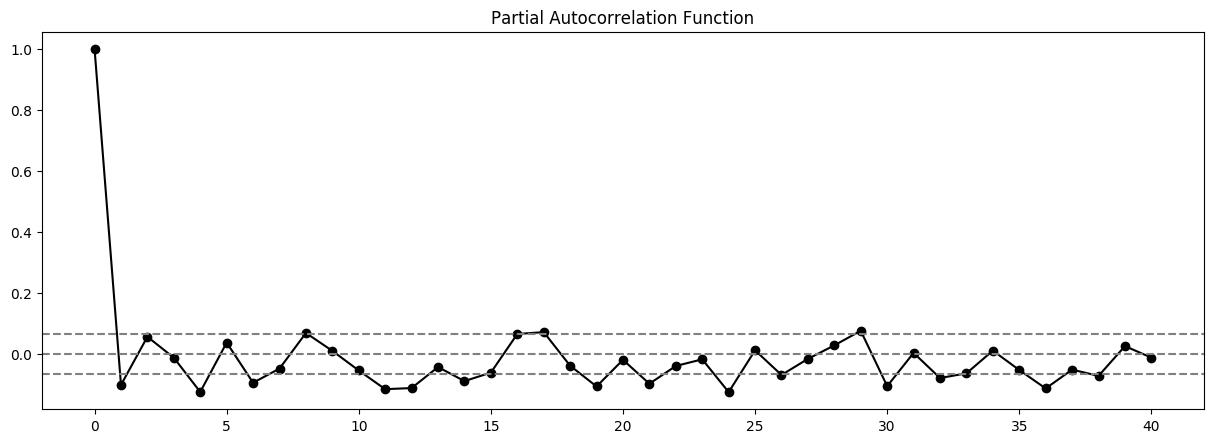

In [68]:
lag_pacf = pacf(prcp_res, nlags=40)

#Plot PACF: 
plt.plot(lag_pacf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function');

__p=2__

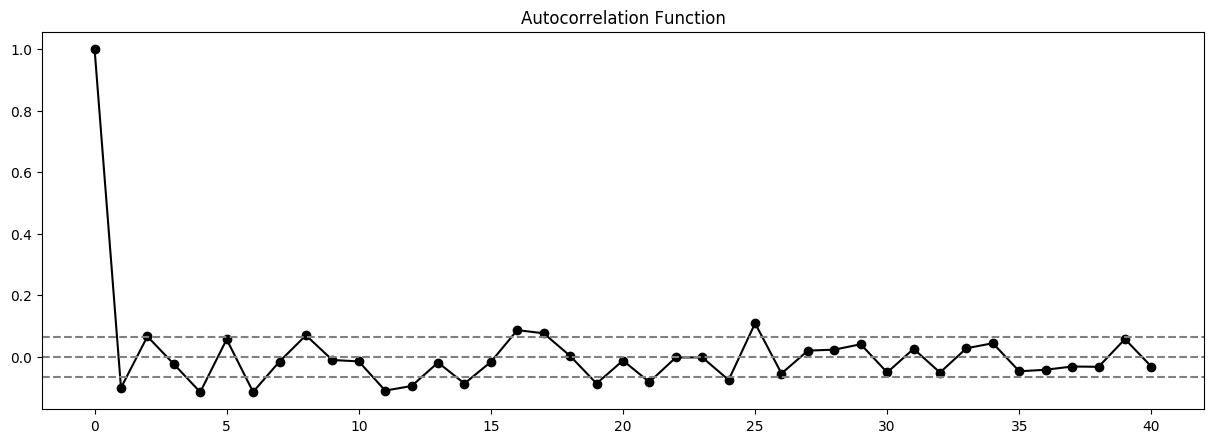

In [69]:
lag_acf = acf(prcp_res, nlags=40)

#Plot ACF: 
plt.plot(lag_acf, 'ok-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(prcp_res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function');

__q=2__

Here, we should take p=0 and q=0, but then model predicts just straight line. Taking 2 as parameters yields in much more realistic prediction

__Fitting model and predicting__

In [70]:
prcp_model = ARIMA(prcp_res, order=(2, 0, 2))
prcp_model_fit = prcp_model.fit(disp=-1)

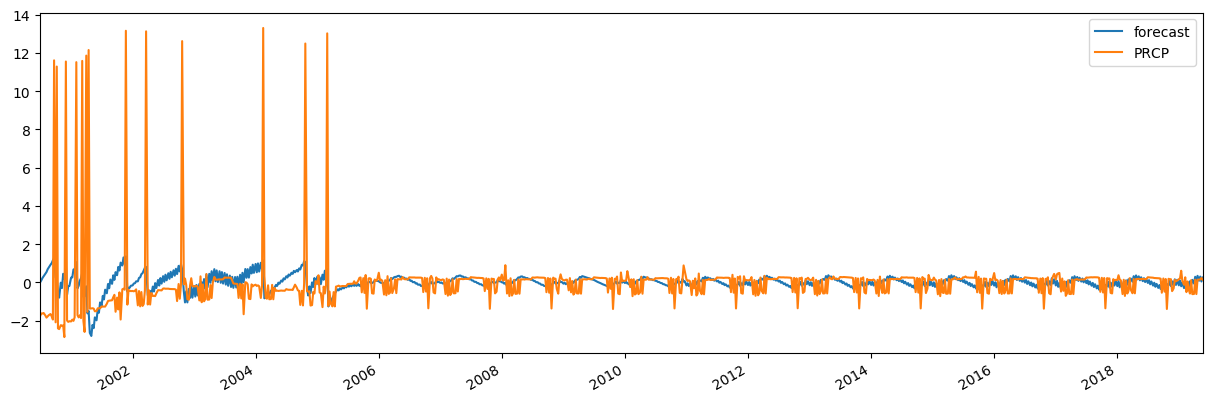

In [71]:
# Actual vs Fitted
prcp_model_fit.plot_predict(dynamic=False)
plt.show()

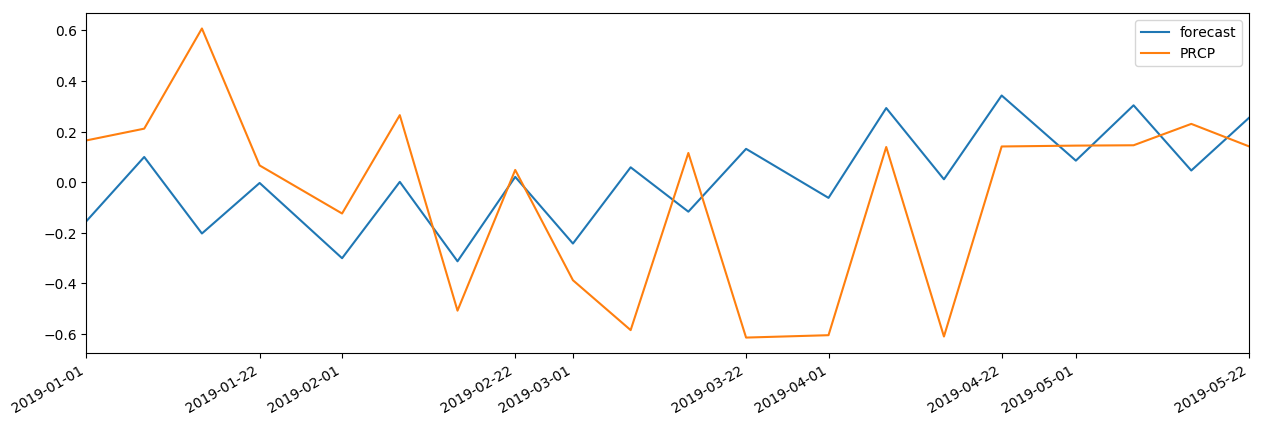

In [72]:
# only 2019 year
prcp_model_fit.plot_predict(start="2019-01-01"  ,dynamic=False)
plt.show()

# Results evaluation

Here, I'll demonstrate how much my prediction differce from real weather data.

In [73]:
from sklearn.metrics import mean_squared_error

def plot_results(original, model_fit, decom_results):
    
    forecast = model_fit.predict(start="2019-01-01")
    trend = decom_results[1].loc["2019-01-01":"2019-05-23",]
    season = decom_results[2].loc["2019-01-01":"2019-05-23",]
    
    predicted = forecast + trend + season
    
    months = sorted(list({str(date)[5:7] for date in original.index}))
    
    predicted_results, original_results = [], []
    
    for month in months:
        or_total, pred_total = 0, 0
        c = 0
        for indx in original.index:
            if str(indx)[5:7] == month:
                or_total += original[indx]
                pred_total += predicted[indx]
                c += 1
        predicted_results.append(pred_total / c)
        original_results.append(or_total / c)
        
    results = pd.DataFrame(data={'Real':original_results, 'Predicted':predicted_results}, 
                           index=months)
    
    print("RMSE:{}\n\n".format(mean_squared_error(original, predicted)**0.5))
                
    plt.plot(original)
    plt.plot(predicted)
    plt.legend(["Original", "Predicted"], loc='upper left')
    plt.show()
    
    
    return results

### Temperature

RMSE:3.0449318226568884




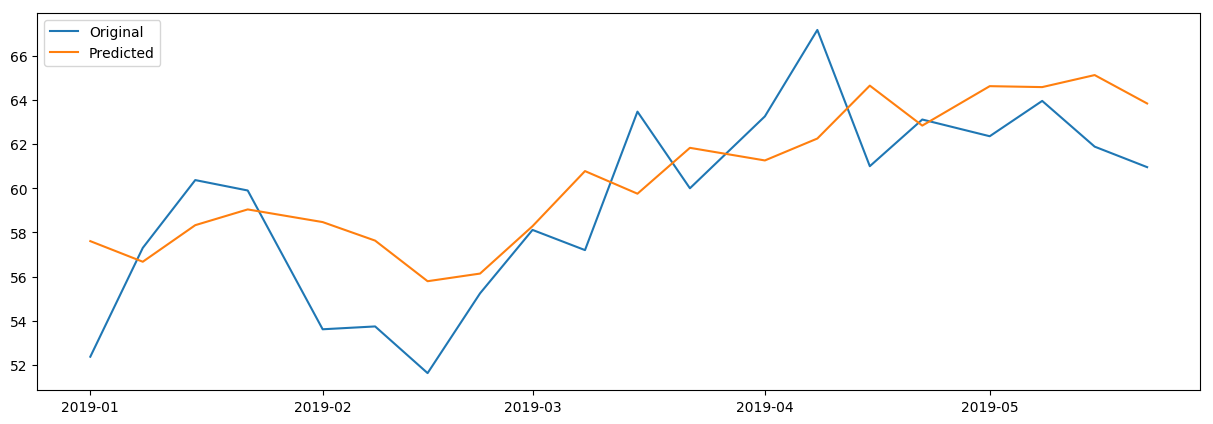

,Real,Predicted
01,57.485714,57.912662
02,53.557143,57.006835
03,59.696429,60.162229
04,63.635714,62.750411
05,62.289286,64.543771


In [74]:
plot_results(temp.loc["2019-01-01":"2019-05-23",], temp_model_fit, temp_results)

### Dew point

RMSE:5.346329976819022




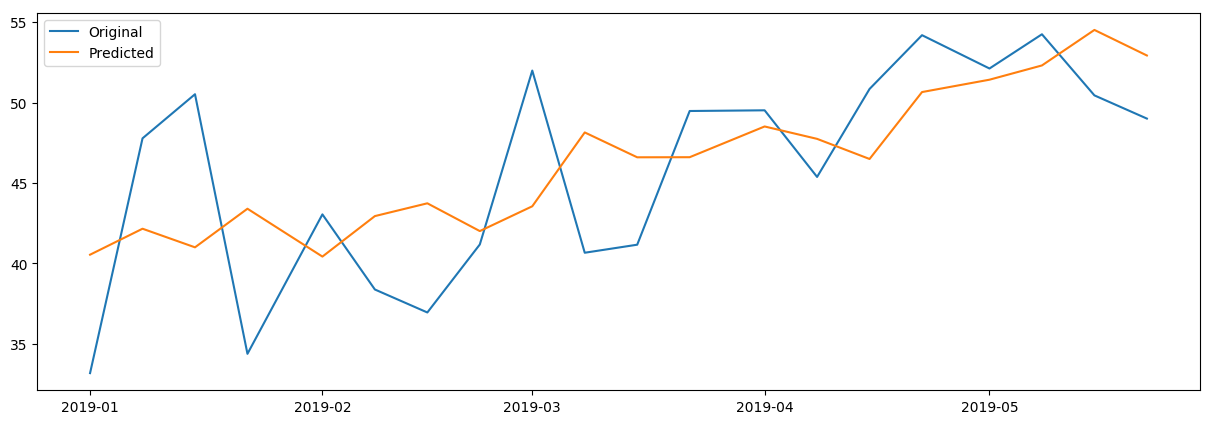

,Real,Predicted
01,41.457143,41.768750
02,39.882143,42.272467
03,45.817857,46.219009
04,49.978571,48.346269
05,51.450000,52.789650


In [75]:
plot_results(dewp.loc["2019-01-01":"2019-05-23",], dewp_model_fit, dewp_results)

### Sea level pressure

RMSE:1.3256247146163973




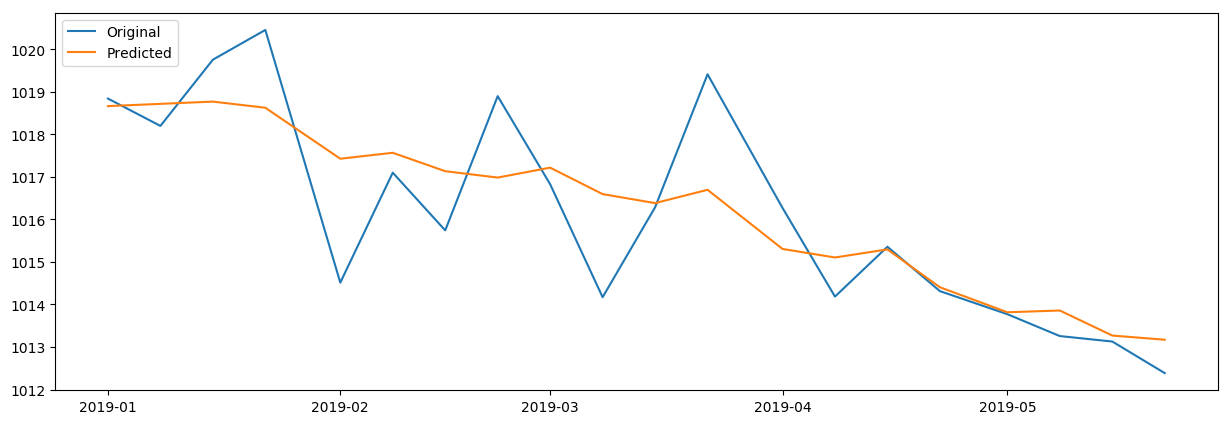

,Real,Predicted
01,1019.314286,1018.695655
02,1016.564286,1017.279070
03,1016.675000,1016.723909
04,1015.032143,1015.028152
05,1013.135714,1013.528985


In [76]:
plot_results(slp.loc["2019-01-01":"2019-05-23",], slp_model_fit, slp_results)

### Station pressure

RMSE:36.461827237282684




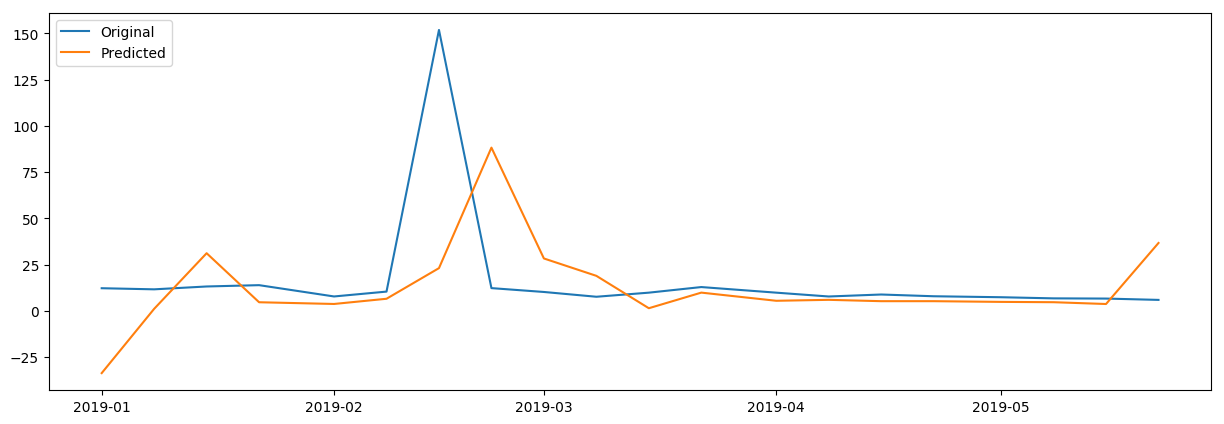

,Real,Predicted
01,12.671429,0.740366
02,45.546429,30.348265
03,10.067857,14.569722
04,8.517857,5.398742
05,6.603571,12.416153


In [77]:
plot_results(stp.loc["2019-01-01":"2019-05-23",], stp_model_fit, stp_results)

### Visibility

RMSE:0.7240444752097206




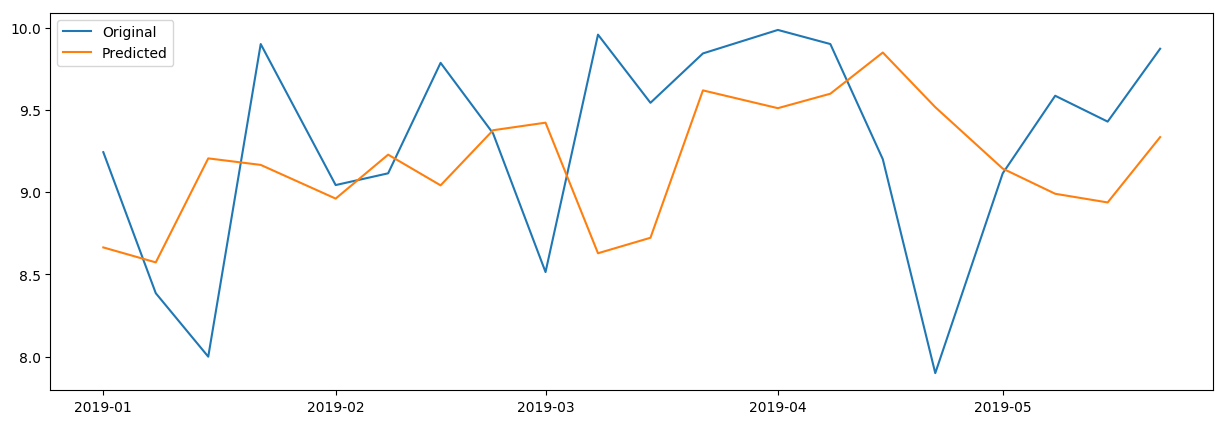

,Real,Predicted
01,8.882143,8.901863
02,9.325000,9.151433
03,9.464286,9.097906
04,9.246429,9.618272
05,9.500000,9.101138


In [78]:
plot_results(visib.loc["2019-01-01":"2019-05-23",], visib_model_fit, visib_results)

### Wind Speed

RMSE:0.6242306647156369




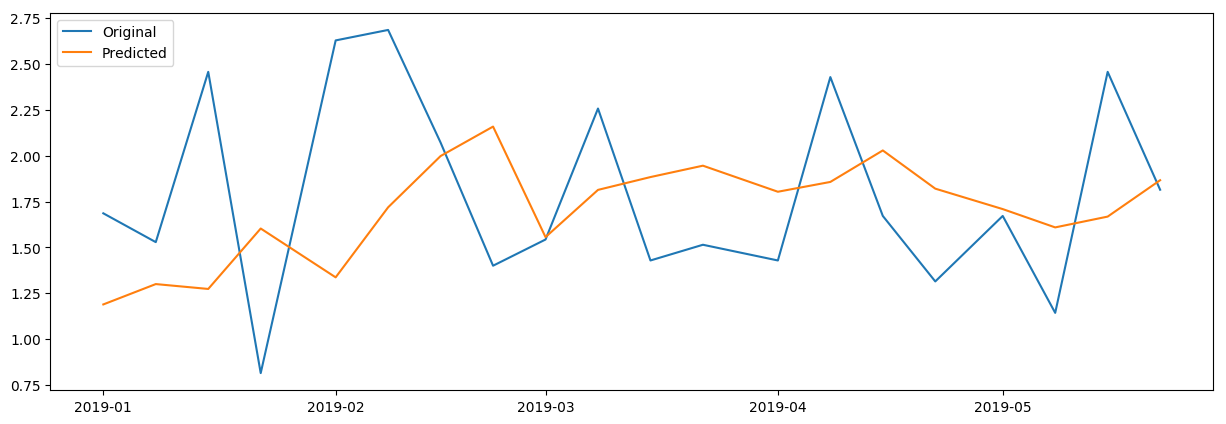

,Real,Predicted
01,1.621429,1.341188
02,2.196429,1.802948
03,1.685714,1.799576
04,1.710714,1.877234
05,1.771429,1.712923


In [79]:
plot_results(wdsp.loc["2019-01-01":"2019-05-23",], wdsp_model_fit, wdsp_results)

### Precipitation amount

RMSE:0.37310906143513806




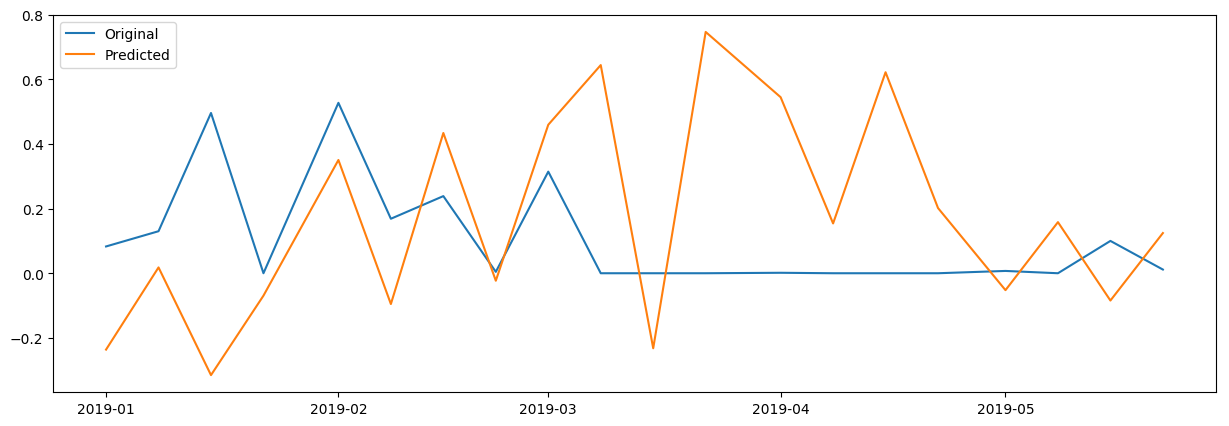

,Real,Predicted
01,0.177143,-0.150653
02,0.234643,0.166437
03,0.078571,0.404381
04,0.000357,0.380489
05,0.029643,0.036411


In [80]:
plot_results(prcp.loc["2019-01-01":"2019-05-23",], prcp_model_fit, prcp_results)